# 前処理大全 SQL+Python版 (Chapter10)

## はじめに
- データベースはPostgreSQL13です
- 初めに以下のセルを実行してください
- セルに %%sql と記載することでSQLを発行することができます
- jupyterからはdescribeコマンドによるテーブル構造の確認ができないため、テーブル構造を確認する場合はlimitを指定したSELECTなどで代用してください
- 使い慣れたSQLクライアントを使っても問題ありません（接続情報は以下の通り）
  - IPアドレス：Docker Desktopの場合はlocalhost、Docker toolboxの場合は192.168.99.100
  - Port:5432
  - database名: dsdojo_db
  - ユーザ名：padawan
  - パスワード:padawan12345
- 大量出力を行うとJupyterが固まることがあるため、出力件数は制限することを推奨します（設問にも出力件数を記載）
    - 結果確認のために表示させる量を適切にコントロールし、作業を軽快にすすめる技術もデータ加工には求められます
- 大量結果が出力された場合は、ファイルが重くなり以降開けなくなることもあります
    - その場合、作業結果は消えますがファイルをGitHubから取り直してください
    - vimエディタなどで大量出力範囲を削除することもできます
- 名前、住所等はダミーデータであり、実在するものではありません

In [215]:
%load_ext sql
import os

pgconfig = {
    'host': 'db',
    'port': os.environ['PG_PORT'],
    'database': os.environ['PG_DATABASE'],
    'user': os.environ['PG_USER'],
    'password': os.environ['PG_PASSWORD'],
}
dsl = 'postgresql://{user}:{password}@{host}:{port}/{database}'.format(**pgconfig)

# MagicコマンドでSQLを書くための設定
%sql $dsl

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


'Connected: padawan@dsdojo_db'

In [216]:
import pandas as pd
import numpy as np
from scipy.sparse import csc_matrix
import datetime
customer_df = pd.read_csv("./data/customer.csv")
reserve_df = pd.read_csv("./data/reserve.csv")
production_df = pd.read_csv("./data/production.csv")
production_missin_df = pd.read_csv("./data/production_missing_num.csv")
production_missin_category_df = pd.read_csv("./data/production_missing_category.csv")

# 演習問題

## 冒頭

- 今日は文字型の話。
- 大きく言語依存と言語非依存の分析がある。
- 言語依存の例
  - 日本語は形態素解析を用いる
  - 英語の場合は空白があるので、空白を目印に分解する。
  - 英語には、三人称単数や過去形などがあるため、語尾をカットしたり、現在形に戻す前処理を行います。
- 言語非依存の例
  - N-gram
    - N文字以下の塊を1文字ずつずらしながら取得する。
    - Nを大きくすることで、長い単語を取り出すことができる。
    >N-gramは、必ずしも1文字を1単位として扱うものではありません。たとえば、1単位を1単語と262 第11章文字型して、連続した単語の固まりを抽出する場合に利用することもあります）。
    - 上記は、単語を最小単位とするN-gramがあるということ。
    - N-gramは、抜け漏れなく分解できるので、検索の前処理や新語抽出の前処理として利用される。
    >たとえば、新たな単語の抽出は、取り出した文字の固まりを種類別にカウントし、カウント数が多いよく出現する固まりは何らかの意味を持っている可能性が高いという傾向を利用して実現できます。
  - RNN
    - 文字単位で入力する場合は、こちらも言語非依存の例となる。
- 得られるデータが少ない場合は、言語依存の手法が有効で、本書でもこちらを扱う。

### 011_character/001: 形態素解析による分解

- 形態素解析は、文法や辞書を用いて分解する方法。
- 自ら開発するのは非常に大変なのでOSSのMeCabを使用する。
- 専門用語が必要な場合は辞書を追加することもある。

<span style="background-color:yellow;">問１：走れメロスのテキストから、MeCabを利用して名詞と動詞の単語を取り出す。</span>

#### R (Awesome)

- RMeCabを使用する

#### Python (Awesome)

- MeCabを使用する方法は他にもいろいろあるが、本書ではnattoというライブラリを使用する。
  - natto初めて聞いたな、今でも使えるか…？

In [3]:
!pip3 install natto-py

  Created wheel for natto-py: filename=natto_py-1.0.0-py3-none-any.whl size=44828 sha256=6191a81214aead092932455a9c4c2026c1ecc171682d99659917d507927f8bb9
  Stored in directory: /home/jovyan/.cache/pip/wheels/c9/52/a0/266fc0dd1990af9ea1db11f4e6b48d9112170dd2ef5e32a98e
Successfully built natto-py


In [5]:
from natto import MeCab

mc = MeCab()

with open("data/txt/meros.txt", "rt") as f:
    txt = f.read()

txt

'メロスは激怒した。必ず、かの邪智暴虐の王を除かなければならぬと決意した。メロスには政治がわからぬ。メロスは、村の牧人である。笛を吹き、羊と遊んで暮して来た。けれども邪悪に対しては、人一倍に敏感であった。きょう未明メロスは村を出発し、野を越え山越え、十里はなれた此のシラクスの市にやって来た。メロスには父も、母も無い。女房も無い。十六の、内気な妹と二人暮しだ。この妹は、村の或る律気な一牧人を、近々、花婿として迎える事になっていた。結婚式も間近かなのである。メロスは、それゆえ、花嫁の衣裳やら祝宴の御馳走やらを買いに、はるばる市にやって来たのだ。先ず、その品々を買い集め、それから都の大路をぶらぶら歩いた。メロスには竹馬の友があった。セリヌンティウスである。今は此のシラクスの市で、石工をしている。その友を、これから訪ねてみるつもりなのだ。久しく逢わなかったのだから、訪ねて行くのが楽しみである。歩いているうちにメロスは、まちの様子を怪しく思った。ひっそりしている。もう既に日も落ちて、まちの暗いのは当りまえだが、けれども、なんだか、夜のせいばかりでは無く、市全体が、やけに寂しい。のんきなメロスも、だんだん不安になって来た。路で逢った若い衆をつかまえて、何かあったのか、二年まえに此の市に来たときは、夜でも皆が歌をうたって、まちは賑やかであった筈だが、と質問した。若い衆は、首を振って答えなかった。しばらく歩いて老爺に逢い、こんどはもっと、語勢を強くして質問した。老爺は答えなかった。メロスは両手で老爺のからだをゆすぶって質問を重ねた。老爺は、あたりをはばかる低声で、わずか答えた。\n'

In [7]:
word_list = []

for part_and_word in mc.parse(txt, as_nodes=True):
    
    # begin of sequence, end of sequenceでない場合
    if not (part_and_word.is_bos() or part_and_word.is_eos()):
        
        part, word = part_and_word.feature.split(',', 1)
        
        if part in ['名詞', '動詞']:
            word_list.append(part_and_word.surface)

word_list

['メロス',
 '激怒',
 'し',
 '邪智',
 '暴虐',
 '王',
 '除か',
 'なら',
 '決意',
 'し',
 'メロス',
 '政治',
 'わから',
 'メロス',
 '村',
 '牧人',
 '笛',
 '吹き',
 '羊',
 '遊ん',
 '暮し',
 '来',
 '邪悪',
 '人一倍',
 '敏感',
 'きょう',
 '未明',
 'メロス',
 '村',
 '出発',
 'し',
 '野',
 '越え',
 '山越え',
 '十',
 '里',
 'なれ',
 '此',
 'シラクス',
 '市',
 'やって来',
 'メロス',
 '父',
 '母',
 '女房',
 '十',
 '六',
 '内気',
 '妹',
 '二',
 '人',
 '暮し',
 '妹',
 '村',
 '律',
 '気',
 '一',
 '牧人',
 '花婿',
 '迎える',
 '事',
 'なっ',
 'い',
 '結婚式',
 '間近',
 'の',
 'メロス',
 'それ',
 'ゆえ',
 '花嫁',
 '衣裳',
 '祝宴',
 '御馳走',
 '買い',
 '市',
 'やって来',
 'の',
 '品々',
 '買い',
 '集め',
 '都',
 '大路',
 '歩い',
 'メロス',
 '竹馬',
 '友',
 'あっ',
 'セリヌンティウス',
 '今',
 '此',
 'シラクス',
 '市',
 '石工',
 'し',
 'いる',
 '友',
 '訪ね',
 'みる',
 'つもり',
 'の',
 '逢わ',
 'の',
 '訪ね',
 '行く',
 'の',
 '楽しみ',
 '歩い',
 'いる',
 'うち',
 'メロス',
 'まち',
 '様子',
 '思っ',
 'し',
 'いる',
 '日',
 '落ち',
 'まち',
 'の',
 '当り',
 'まえ',
 '夜',
 'せい',
 '市',
 '全体',
 'のんき',
 'メロス',
 '不安',
 'なっ',
 '来',
 '路',
 '逢っ',
 '若い衆',
 'つかまえ',
 '何',
 'あっ',
 'の',
 '二',
 '年',
 'まえ',
 '此',
 '市',
 '来',
 'とき',
 '夜',
 '皆',

### 011_character/002:単語の集合データに変換

#### 語順を考慮する

- その後、語順を考慮するかどうかも重要な要素である。
- 考慮するかどうかは、後続のタスクによって決まる。
  - 文章のネガポジ判定の場合は、語順を考慮する必要性が高い。
  - 文書分類は、語順を考慮する必要性が低い
- 語順を考慮する場合は、構文解析という前処理をすることが多い。
- SyntaxNetなどで簡単に実現できるが、活用が専門家以外難しい。

#### 語順を考慮しない

- 語順を考慮しない形式は、bag of wordsと呼ばれる。
- 本書ではこれらを中心に解説する。

<span style="background-color:yellow;">問２：３つのテキストファイルごとにbag of wordsを作成せよ。</span>

#### R (Awesome)

- RMeCabでは、形態素解析とbag of wordsを同時に行うdocDFが提供されている。

#### Python (Awesome)
- MeCab + gensimでbag of wordsを計算する。

In [9]:
!pip3 install gensim

     |████████████████████████████████| 24.0 MB 10.4 MB/s eta 0:00:01     |█████████████████████▏          | 15.9 MB 15.3 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 5.8 MB/s  eta 0:00:01


In [22]:
from natto import MeCab
from gensim import corpora, matutils
import pathlib

mc = MeCab()

txt_word_list = []

files = [ *pathlib.Path('data/txt').glob('*.txt')]
files

for file in files:
    with open(file, "rt") as f:
        txt = f.read()
    
    word_list = []
    for part_and_word in mc.parse(txt, as_nodes=True):

        # begin of sequence, end of sequenceでない場合
        if not (part_and_word.is_bos() or part_and_word.is_eos()):

            part, word = part_and_word.feature.split(',', 1)

            if part in ['名詞', '動詞']:
                word_list.append(part_and_word.surface)

    txt_word_list.append(word_list)

# 出現単語を辞書化（語彙情報）
corpus_dic = corpora.Dictionary(txt_word_list)

# 各文章を出現回数に変換
corpus_list = [corpus_dic.doc2bow(word_list) for word_list in txt_word_list]

# sparse行列に変換
word_matrix = matutils.corpus2csc(corpus_list)

### 011_character/003:TF-IDFによる単語の重要度調整

- TFは単語の出現割合
- IDFはレア度合

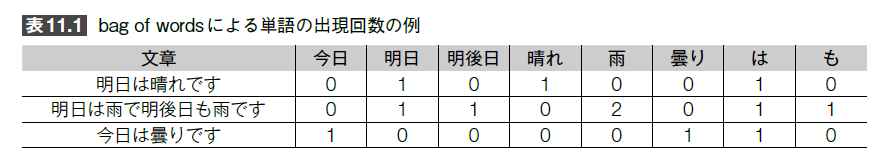

- 正規化について書いてある。
- TFは文章の単語数には関係ないが、IDFはそれと無関係なので、正規化しないと文書間で絶対的な大きさが合わないため正規化する？
- 手前みそですが以下に私も解説を書きました。
  - [https://nakamura-shogo.gitbook.io/git-book-ml-wiki/nlp/nlp_tf_idf](https://nakamura-shogo.gitbook.io/git-book-ml-wiki/nlp/nlp_tf_idf)

<span style="background-color:yellow;">問３：前述の３ファイルでTF-IDFを計算せよ。</span>

#### R (Awesome)

- docDFでweight引数を利用すれば計算できる。

#### Python (Awesome)
- 引き算してtimedelta64型になるので、そこから要素を取り出せる。
- R同様、年月の差分を計算する時は、要素から計算しないといけない。
- なんか小数点以下が切り捨てられている気がするんだが、要求されていることと合っていないかも。。。

In [26]:
from gensim import matutils, models

# TF-IDFのモデルを作成
tfidf_model = models.TfidfModel(corpus_list, normalize=True)

corpus_list_tfidf = tfidf_model[corpus_list]
word_matrix = matutils.corpus2csc(corpus_list_tfidf)

In [33]:
import pandas as pd
pd.DataFrame(word_matrix.todense().T)

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,226,227,228,229,230,231
0,0.104079,0.104079,0.038412,0.076825,0.038412,0.104079,0.104079,0.208158,0.0,0.416315,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.160429,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.026181,0.000000,0.026181,0.000000,0.000000,0.000000,0.0,0.000000,...,0.070937,0.070937,0.070937,0.070937,0.070937,0.070937,0.070937,0.070937,0.070937,0.070937


#### Python: その他の解法

- sklearnのTfidfVectorizerを使うと、手順が簡易で済む。
- 正規化はされているか…？
  - 引数に`norm='l2'`があるのでやってそう

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [ ' '.join(t) for t in txt_word_list]
vectorizer = TfidfVectorizer(token_pattern="(?u)\\b\\w+\\b")
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()
print(X.shape)

(3, 232)


In [38]:
pd.DataFrame(X.todense())

,0,1,2,3,4,5,6,7,8,9,...,222,223,224,225,226,227,228,229,230,231
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090477,0.000000,0.000000,...,0.000000,0.000000,0.090477,0.000000,0.090477,0.090477,0.090477,0.090477,0.000000,0.000000
1,0.050058,0.100117,0.000000,0.050058,0.114212,0.050058,0.050058,0.000000,0.050058,0.050058,...,0.050058,0.050058,0.000000,0.050058,0.000000,0.000000,0.000000,0.000000,0.000000,0.050058
2,0.000000,0.000000,0.136212,0.000000,0.051796,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068106,0.000000
